# 순환 신경망(LSTM)모델 만들어보기 

- [출처 : 순환 신경망 모델 만들어보기](https://tykimos.github.io/2017/04/09/RNN_Layer_Talk/)

## 2. non-stateful LSTM model

이번에는 간단한 기본 LSTM 모델로 먼저 테스트를 해보겠습니다. 모델 구성은 다음과 같이 하였습니다.

- 128 메모리 셀을 가진 LSTM 레이어 1개와 Dense 레이어로 구성
- 입력은 샘플이 50개, 타임스텝이 4개, 속성이 1개로 구성
- 상태유지(stateful) 모드 비활성화

케라스에서는 아래와 같이 LSTM을 구성할 수 있습니다.

- model = Sequential()  
    model.add(LSTM(128, input_shape = (4, 1)))  
    model.add(Dense(one_hot_vec_size, activation='softmax'))  

LSTM을 제대로 활용하기 위해서는 `상태유지 모드`, `배치사이즈`, `타임스텝`, `속성`에 대한 개념에 이해가 필요합니다.

본 절에서는 타임스텝에 대해서 먼저 알아보겠습니다. 

- 타임스텝이란 하나의 샘플에 포함된 시퀀스 개수입니다. 이는 앞서 살펴본 “input_length”와 동일합니다. 현재 문제에서는 매 샘플마다 4개의 값을 입력하므로 타임스텝이 4개로 지정할 수 있습니다. 즉 윈도우 크기와 동일하게 타임스텝으로 설정하면 됩니다.
- 속성에 대해서는 나중에 알아보겠지만, 입력되는 음표 1개당 하나의 인덱스 값을 입력하므로 속성이 1개입니다. 나중에 이 속성의 개수를 다르게 해서 테스트 해보겠습니다. 
- 인자로 “input_shape = (4, 1)’과 “input_dim = 1, input_length = 4”는 동일합니다. 설정한 LSTM 모델에 따라 입력할 데이터셋도 샘플 수, 타임스텝 수, 속성 수 형식으로 맞추어야 합니다. 따라서 앞서 구성한 x_train를 아래와 같이 형식을 변환합니다.

이 모델로 악보를 학습할 경우, 다층 퍼셉트론 모델과 동일하게 4개의 음표를 입력으로 받고, 그 다음 음표가 라벨값으로 지정됩니다. 이 과정을 곡이 마칠 때까지 반복하게 됩니다. 다층 퍼셉트론 모델과 차이점이 있다면, 다층 퍼셉트론 모델에서는 4개의 음표가 4개의 속성으로 입력되고, LSTM에서는 4개의 음표가 4개의 시퀀스 입력으로 들어갑니다. 여기서 속성은 1개입니다.

In [2]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

# 1. 데이터 준비하기
        
# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)

# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타입스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50, 4, 1))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

Using TensorFlow backend.


(50, 5)
one hot encoding vector size is  12


In [7]:
# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, input_shape = (4, 1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

In [8]:
# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=14, verbose=2, callbacks=[history])

W0822 12:07:26.900957  6576 deprecation.py:323] From C:\AN\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0822 12:07:27.371984  6576 deprecation_wrapper.py:119] From C:\AN\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/2000
 - 1s - loss: 2.4926 - acc: 0.0600
Epoch 2/2000
 - 0s - loss: 2.4531 - acc: 0.3000
Epoch 3/2000
 - 0s - loss: 2.4142 - acc: 0.3400
Epoch 4/2000
 - 0s - loss: 2.3740 - acc: 0.3400
Epoch 5/2000
 - 0s - loss: 2.3242 - acc: 0.3400
Epoch 6/2000
 - 0s - loss: 2.2695 - acc: 0.3400
Epoch 7/2000
 - 0s - loss: 2.1963 - acc: 0.3400
Epoch 8/2000
 - 0s - loss: 2.1249 - acc: 0.3400
Epoch 9/2000
 - 0s - loss: 2.0473 - acc: 0.3400
Epoch 10/2000
 - 0s - loss: 1.9872 - acc: 0.3400
Epoch 11/2000
 - 0s - loss: 1.9668 - acc: 0.3400
Epoch 12/2000
 - 0s - loss: 1.9697 - acc: 0.3400
Epoch 13/2000
 - 0s - loss: 1.9590 - acc: 0.3400
Epoch 14/2000
 - 0s - loss: 1.9417 - acc: 0.3400
Epoch 15/2000
 - 0s - loss: 1.9319 - acc: 0.3400
Epoch 16/2000
 - 0s - loss: 1.9246 - acc: 0.3400
Epoch 17/2000
 - 0s - loss: 1.9196 - acc: 0.3400
Epoch 18/2000
 - 0s - loss: 1.9159 - acc: 0.3400
Epoch 19/2000
 - 0s - loss: 1.9094 - acc: 0.3400
Epoch 20/2000
 - 0s - loss: 1.9068 - acc: 0.3400
Epoch 21/2000
 - 0s - loss: 1

 - 0s - loss: 1.6011 - acc: 0.4400
Epoch 168/2000
 - 0s - loss: 1.6085 - acc: 0.4600
Epoch 169/2000
 - 0s - loss: 1.5971 - acc: 0.4600
Epoch 170/2000
 - 0s - loss: 1.6058 - acc: 0.3600
Epoch 171/2000
 - 0s - loss: 1.6068 - acc: 0.3600
Epoch 172/2000
 - 0s - loss: 1.6004 - acc: 0.4600
Epoch 173/2000
 - 0s - loss: 1.5942 - acc: 0.4600
Epoch 174/2000
 - 0s - loss: 1.6003 - acc: 0.4400
Epoch 175/2000
 - 0s - loss: 1.5859 - acc: 0.4400
Epoch 176/2000
 - 0s - loss: 1.6171 - acc: 0.4400
Epoch 177/2000
 - 0s - loss: 1.5849 - acc: 0.4200
Epoch 178/2000
 - 0s - loss: 1.5939 - acc: 0.4200
Epoch 179/2000
 - 0s - loss: 1.5914 - acc: 0.4200
Epoch 180/2000
 - 0s - loss: 1.6028 - acc: 0.3800
Epoch 181/2000
 - 0s - loss: 1.5873 - acc: 0.3800
Epoch 182/2000
 - 0s - loss: 1.5853 - acc: 0.4400
Epoch 183/2000
 - 0s - loss: 1.5792 - acc: 0.4400
Epoch 184/2000
 - 0s - loss: 1.5733 - acc: 0.4400
Epoch 185/2000
 - 0s - loss: 1.5724 - acc: 0.4400
Epoch 186/2000
 - 0s - loss: 1.5749 - acc: 0.4400
Epoch 187/2000


Epoch 332/2000
 - 0s - loss: 1.2934 - acc: 0.5400
Epoch 333/2000
 - 0s - loss: 1.2886 - acc: 0.5400
Epoch 334/2000
 - 0s - loss: 1.2766 - acc: 0.5000
Epoch 335/2000
 - 0s - loss: 1.2754 - acc: 0.5400
Epoch 336/2000
 - 0s - loss: 1.2700 - acc: 0.5800
Epoch 337/2000
 - 0s - loss: 1.2602 - acc: 0.5200
Epoch 338/2000
 - 0s - loss: 1.2704 - acc: 0.5400
Epoch 339/2000
 - 0s - loss: 1.2599 - acc: 0.5800
Epoch 340/2000
 - 0s - loss: 1.2560 - acc: 0.5800
Epoch 341/2000
 - 0s - loss: 1.2662 - acc: 0.5000
Epoch 342/2000
 - 0s - loss: 1.2564 - acc: 0.5000
Epoch 343/2000
 - 0s - loss: 1.2578 - acc: 0.5600
Epoch 344/2000
 - 0s - loss: 1.2585 - acc: 0.5400
Epoch 345/2000
 - 0s - loss: 1.2466 - acc: 0.5600
Epoch 346/2000
 - 0s - loss: 1.2435 - acc: 0.5400
Epoch 347/2000
 - 0s - loss: 1.2540 - acc: 0.5000
Epoch 348/2000
 - 0s - loss: 1.2374 - acc: 0.5400
Epoch 349/2000
 - 0s - loss: 1.2651 - acc: 0.5400
Epoch 350/2000
 - 0s - loss: 1.2537 - acc: 0.5200
Epoch 351/2000
 - 0s - loss: 1.2520 - acc: 0.5600


Epoch 496/2000
 - 0s - loss: 0.9321 - acc: 0.6200
Epoch 497/2000
 - 0s - loss: 0.9535 - acc: 0.6200
Epoch 498/2000
 - 0s - loss: 0.9367 - acc: 0.6400
Epoch 499/2000
 - 0s - loss: 0.9295 - acc: 0.6400
Epoch 500/2000
 - 0s - loss: 0.9272 - acc: 0.6400
Epoch 501/2000
 - 0s - loss: 0.9290 - acc: 0.6400
Epoch 502/2000
 - 0s - loss: 0.9397 - acc: 0.6400
Epoch 503/2000
 - 0s - loss: 0.9240 - acc: 0.6600
Epoch 504/2000
 - 0s - loss: 0.9308 - acc: 0.6200
Epoch 505/2000
 - 0s - loss: 0.9284 - acc: 0.6400
Epoch 506/2000
 - 0s - loss: 0.9343 - acc: 0.6800
Epoch 507/2000
 - 0s - loss: 0.9188 - acc: 0.6400
Epoch 508/2000
 - 0s - loss: 0.9051 - acc: 0.6800
Epoch 509/2000
 - 0s - loss: 0.9247 - acc: 0.6800
Epoch 510/2000
 - 0s - loss: 0.9140 - acc: 0.6800
Epoch 511/2000
 - 0s - loss: 0.9039 - acc: 0.6600
Epoch 512/2000
 - 0s - loss: 0.9129 - acc: 0.6400
Epoch 513/2000
 - 0s - loss: 0.9172 - acc: 0.6600
Epoch 514/2000
 - 0s - loss: 0.9026 - acc: 0.7000
Epoch 515/2000
 - 0s - loss: 0.8982 - acc: 0.6400


Epoch 660/2000
 - 0s - loss: 0.6709 - acc: 0.7600
Epoch 661/2000
 - 0s - loss: 0.6658 - acc: 0.7800
Epoch 662/2000
 - 0s - loss: 0.6735 - acc: 0.7400
Epoch 663/2000
 - 0s - loss: 0.6592 - acc: 0.7600
Epoch 664/2000
 - 0s - loss: 0.6552 - acc: 0.7600
Epoch 665/2000
 - 0s - loss: 0.6578 - acc: 0.7600
Epoch 666/2000
 - 0s - loss: 0.6571 - acc: 0.7800
Epoch 667/2000
 - 0s - loss: 0.6685 - acc: 0.7200
Epoch 668/2000
 - 0s - loss: 0.6580 - acc: 0.8000
Epoch 669/2000
 - 0s - loss: 0.6701 - acc: 0.8200
Epoch 670/2000
 - 0s - loss: 0.6462 - acc: 0.7800
Epoch 671/2000
 - 0s - loss: 0.6639 - acc: 0.7800
Epoch 672/2000
 - 0s - loss: 0.6497 - acc: 0.8200
Epoch 673/2000
 - 0s - loss: 0.6622 - acc: 0.7400
Epoch 674/2000
 - 0s - loss: 0.6482 - acc: 0.7600
Epoch 675/2000
 - 0s - loss: 0.6657 - acc: 0.7200
Epoch 676/2000
 - 0s - loss: 0.6478 - acc: 0.7600
Epoch 677/2000
 - 0s - loss: 0.6434 - acc: 0.7600
Epoch 678/2000
 - 0s - loss: 0.6599 - acc: 0.7600
Epoch 679/2000
 - 0s - loss: 0.6548 - acc: 0.7600


Epoch 824/2000
 - 0s - loss: 0.5427 - acc: 0.8200
Epoch 825/2000
 - 0s - loss: 0.5186 - acc: 0.8400
Epoch 826/2000
 - 0s - loss: 0.5512 - acc: 0.8000
Epoch 827/2000
 - 0s - loss: 0.5043 - acc: 0.8200
Epoch 828/2000
 - 0s - loss: 0.5199 - acc: 0.8200
Epoch 829/2000
 - 0s - loss: 0.5141 - acc: 0.8200
Epoch 830/2000
 - 0s - loss: 0.5240 - acc: 0.8200
Epoch 831/2000
 - 0s - loss: 0.5102 - acc: 0.8200
Epoch 832/2000
 - 0s - loss: 0.4960 - acc: 0.8400
Epoch 833/2000
 - 0s - loss: 0.4991 - acc: 0.8600
Epoch 834/2000
 - 0s - loss: 0.5125 - acc: 0.8600
Epoch 835/2000
 - 0s - loss: 0.4993 - acc: 0.8200
Epoch 836/2000
 - 0s - loss: 0.4961 - acc: 0.8400
Epoch 837/2000
 - 0s - loss: 0.5371 - acc: 0.8000
Epoch 838/2000
 - 0s - loss: 0.5135 - acc: 0.8400
Epoch 839/2000
 - 0s - loss: 0.5172 - acc: 0.8400
Epoch 840/2000
 - 0s - loss: 0.4943 - acc: 0.8800
Epoch 841/2000
 - 0s - loss: 0.5114 - acc: 0.8200
Epoch 842/2000
 - 0s - loss: 0.5005 - acc: 0.8400
Epoch 843/2000
 - 0s - loss: 0.5004 - acc: 0.8600


Epoch 988/2000
 - 0s - loss: 0.4527 - acc: 0.8400
Epoch 989/2000
 - 0s - loss: 0.4462 - acc: 0.8400
Epoch 990/2000
 - 0s - loss: 0.4241 - acc: 0.8600
Epoch 991/2000
 - 0s - loss: 0.4425 - acc: 0.8600
Epoch 992/2000
 - 0s - loss: 0.4446 - acc: 0.8400
Epoch 993/2000
 - 0s - loss: 0.4396 - acc: 0.8600
Epoch 994/2000
 - 0s - loss: 0.4817 - acc: 0.8000
Epoch 995/2000
 - 0s - loss: 0.4602 - acc: 0.8400
Epoch 996/2000
 - 0s - loss: 0.4774 - acc: 0.8200
Epoch 997/2000
 - 0s - loss: 0.4453 - acc: 0.8600
Epoch 998/2000
 - 0s - loss: 0.4479 - acc: 0.8400
Epoch 999/2000
 - 0s - loss: 0.4457 - acc: 0.8400
Epoch 1000/2000
 - 0s - loss: 0.4343 - acc: 0.8600
Epoch 1001/2000
 - 0s - loss: 0.4265 - acc: 0.8600
Epoch 1002/2000
 - 0s - loss: 0.4393 - acc: 0.8200
Epoch 1003/2000
 - 0s - loss: 0.4141 - acc: 0.8800
Epoch 1004/2000
 - 0s - loss: 0.4366 - acc: 0.8400
Epoch 1005/2000
 - 0s - loss: 0.4098 - acc: 0.8600
Epoch 1006/2000
 - 0s - loss: 0.4681 - acc: 0.8400
Epoch 1007/2000
 - 0s - loss: 0.4251 - acc:

Epoch 1149/2000
 - 0s - loss: 0.3775 - acc: 0.8800
Epoch 1150/2000
 - 0s - loss: 0.3752 - acc: 0.8600
Epoch 1151/2000
 - 0s - loss: 0.3799 - acc: 0.8600
Epoch 1152/2000
 - 0s - loss: 0.3736 - acc: 0.8400
Epoch 1153/2000
 - 0s - loss: 0.3780 - acc: 0.8600
Epoch 1154/2000
 - 0s - loss: 0.3699 - acc: 0.8600
Epoch 1155/2000
 - 0s - loss: 0.3751 - acc: 0.8400
Epoch 1156/2000
 - 0s - loss: 0.3853 - acc: 0.8600
Epoch 1157/2000
 - 0s - loss: 0.3821 - acc: 0.8800
Epoch 1158/2000
 - 0s - loss: 0.4086 - acc: 0.8400
Epoch 1159/2000
 - 0s - loss: 0.3725 - acc: 0.8600
Epoch 1160/2000
 - 0s - loss: 0.3856 - acc: 0.8600
Epoch 1161/2000
 - 0s - loss: 0.3925 - acc: 0.8800
Epoch 1162/2000
 - 0s - loss: 0.3946 - acc: 0.8400
Epoch 1163/2000
 - 0s - loss: 0.3679 - acc: 0.8600
Epoch 1164/2000
 - 0s - loss: 0.3678 - acc: 0.8400
Epoch 1165/2000
 - 0s - loss: 0.3790 - acc: 0.8600
Epoch 1166/2000
 - 0s - loss: 0.3738 - acc: 0.8800
Epoch 1167/2000
 - 0s - loss: 0.3780 - acc: 0.8400
Epoch 1168/2000
 - 0s - loss: 0

Epoch 1310/2000
 - 0s - loss: 0.3670 - acc: 0.8400
Epoch 1311/2000
 - 0s - loss: 0.3525 - acc: 0.8600
Epoch 1312/2000
 - 0s - loss: 0.3561 - acc: 0.8800
Epoch 1313/2000
 - 0s - loss: 0.3429 - acc: 0.8800
Epoch 1314/2000
 - 0s - loss: 0.3394 - acc: 0.8600
Epoch 1315/2000
 - 0s - loss: 0.3619 - acc: 0.8600
Epoch 1316/2000
 - 0s - loss: 0.3687 - acc: 0.8400
Epoch 1317/2000
 - 0s - loss: 0.3644 - acc: 0.8600
Epoch 1318/2000
 - 0s - loss: 0.3833 - acc: 0.8400
Epoch 1319/2000
 - 0s - loss: 0.3475 - acc: 0.8600
Epoch 1320/2000
 - 0s - loss: 0.3625 - acc: 0.8600
Epoch 1321/2000
 - 0s - loss: 0.3414 - acc: 0.8800
Epoch 1322/2000
 - 0s - loss: 0.3466 - acc: 0.8400
Epoch 1323/2000
 - 0s - loss: 0.3618 - acc: 0.8600
Epoch 1324/2000
 - 0s - loss: 0.3587 - acc: 0.8600
Epoch 1325/2000
 - 0s - loss: 0.3609 - acc: 0.8600
Epoch 1326/2000
 - 0s - loss: 0.3563 - acc: 0.8600
Epoch 1327/2000
 - 0s - loss: 0.3366 - acc: 0.8600
Epoch 1328/2000
 - 0s - loss: 0.3393 - acc: 0.8400
Epoch 1329/2000
 - 0s - loss: 0

Epoch 1471/2000
 - 0s - loss: 0.3655 - acc: 0.8600
Epoch 1472/2000
 - 0s - loss: 0.3381 - acc: 0.8600
Epoch 1473/2000
 - 0s - loss: 0.4097 - acc: 0.8600
Epoch 1474/2000
 - 0s - loss: 0.3027 - acc: 0.9200
Epoch 1475/2000
 - 0s - loss: 0.3943 - acc: 0.8600
Epoch 1476/2000
 - 0s - loss: 0.3349 - acc: 0.8600
Epoch 1477/2000
 - 0s - loss: 0.3737 - acc: 0.8800
Epoch 1478/2000
 - 0s - loss: 0.3270 - acc: 0.8800
Epoch 1479/2000
 - 0s - loss: 0.3275 - acc: 0.8600
Epoch 1480/2000
 - 0s - loss: 0.3314 - acc: 0.8600
Epoch 1481/2000
 - 0s - loss: 0.3203 - acc: 0.8800
Epoch 1482/2000
 - 0s - loss: 0.3247 - acc: 0.8800
Epoch 1483/2000
 - 0s - loss: 0.3338 - acc: 0.8400
Epoch 1484/2000
 - 0s - loss: 0.3162 - acc: 0.8600
Epoch 1485/2000
 - 0s - loss: 0.3294 - acc: 0.8400
Epoch 1486/2000
 - 0s - loss: 0.3130 - acc: 0.8600
Epoch 1487/2000
 - 0s - loss: 0.3148 - acc: 0.8600
Epoch 1488/2000
 - 0s - loss: 0.3143 - acc: 0.8800
Epoch 1489/2000
 - 0s - loss: 0.3139 - acc: 0.8800
Epoch 1490/2000
 - 0s - loss: 0

Epoch 1632/2000
 - 0s - loss: 0.3029 - acc: 0.9000
Epoch 1633/2000
 - 0s - loss: 0.3278 - acc: 0.8800
Epoch 1634/2000
 - 0s - loss: 0.3294 - acc: 0.8400
Epoch 1635/2000
 - 0s - loss: 0.3189 - acc: 0.8800
Epoch 1636/2000
 - 0s - loss: 0.3144 - acc: 0.8600
Epoch 1637/2000
 - 0s - loss: 0.3055 - acc: 0.9000
Epoch 1638/2000
 - 0s - loss: 0.3001 - acc: 0.9000
Epoch 1639/2000
 - 0s - loss: 0.3021 - acc: 0.8800
Epoch 1640/2000
 - 0s - loss: 0.3098 - acc: 0.8600
Epoch 1641/2000
 - 0s - loss: 0.2943 - acc: 0.8800
Epoch 1642/2000
 - 0s - loss: 0.3102 - acc: 0.8600
Epoch 1643/2000
 - 0s - loss: 0.2945 - acc: 0.8600
Epoch 1644/2000
 - 0s - loss: 0.3016 - acc: 0.8800
Epoch 1645/2000
 - 0s - loss: 0.3069 - acc: 0.8600
Epoch 1646/2000
 - 0s - loss: 0.2996 - acc: 0.8600
Epoch 1647/2000
 - 0s - loss: 0.2971 - acc: 0.8800
Epoch 1648/2000
 - 0s - loss: 0.2985 - acc: 0.8600
Epoch 1649/2000
 - 0s - loss: 0.2997 - acc: 0.9000
Epoch 1650/2000
 - 0s - loss: 0.3002 - acc: 0.8800
Epoch 1651/2000
 - 0s - loss: 0

Epoch 1793/2000
 - 0s - loss: 0.2917 - acc: 0.8800
Epoch 1794/2000
 - 0s - loss: 0.2931 - acc: 0.8800
Epoch 1795/2000
 - 0s - loss: 0.2970 - acc: 0.8800
Epoch 1796/2000
 - 0s - loss: 0.2895 - acc: 0.8600
Epoch 1797/2000
 - 0s - loss: 0.2849 - acc: 0.9000
Epoch 1798/2000
 - 0s - loss: 0.2785 - acc: 0.8800
Epoch 1799/2000
 - 0s - loss: 0.2938 - acc: 0.9000
Epoch 1800/2000
 - 0s - loss: 0.2792 - acc: 0.8800
Epoch 1801/2000
 - 0s - loss: 0.2865 - acc: 0.8800
Epoch 1802/2000
 - 0s - loss: 0.3084 - acc: 0.8600
Epoch 1803/2000
 - 0s - loss: 0.2851 - acc: 0.8800
Epoch 1804/2000
 - 0s - loss: 0.2889 - acc: 0.8800
Epoch 1805/2000
 - 0s - loss: 0.2898 - acc: 0.8800
Epoch 1806/2000
 - 0s - loss: 0.2787 - acc: 0.8800
Epoch 1807/2000
 - 0s - loss: 0.3024 - acc: 0.8800
Epoch 1808/2000
 - 0s - loss: 0.3031 - acc: 0.8800
Epoch 1809/2000
 - 0s - loss: 0.3091 - acc: 0.8400
Epoch 1810/2000
 - 0s - loss: 0.2806 - acc: 0.8800
Epoch 1811/2000
 - 0s - loss: 0.2851 - acc: 0.8800
Epoch 1812/2000
 - 0s - loss: 0

Epoch 1954/2000
 - 0s - loss: 0.2949 - acc: 0.8600
Epoch 1955/2000
 - 0s - loss: 0.2728 - acc: 0.8800
Epoch 1956/2000
 - 0s - loss: 0.2844 - acc: 0.8600
Epoch 1957/2000
 - 0s - loss: 0.2812 - acc: 0.8800
Epoch 1958/2000
 - 0s - loss: 0.2771 - acc: 0.9000
Epoch 1959/2000
 - 0s - loss: 0.2713 - acc: 0.9000
Epoch 1960/2000
 - 0s - loss: 0.2795 - acc: 0.8800
Epoch 1961/2000
 - 0s - loss: 0.2778 - acc: 0.8600
Epoch 1962/2000
 - 0s - loss: 0.2802 - acc: 0.8600
Epoch 1963/2000
 - 0s - loss: 0.2707 - acc: 0.9000
Epoch 1964/2000
 - 0s - loss: 0.2688 - acc: 0.9000
Epoch 1965/2000
 - 0s - loss: 0.2721 - acc: 0.9000
Epoch 1966/2000
 - 0s - loss: 0.2745 - acc: 0.9000
Epoch 1967/2000
 - 0s - loss: 0.2733 - acc: 0.8800
Epoch 1968/2000
 - 0s - loss: 0.2858 - acc: 0.8600
Epoch 1969/2000
 - 0s - loss: 0.2723 - acc: 0.8800
Epoch 1970/2000
 - 0s - loss: 0.2852 - acc: 0.8400
Epoch 1971/2000
 - 0s - loss: 0.2818 - acc: 0.8800
Epoch 1972/2000
 - 0s - loss: 0.2765 - acc: 0.8800
Epoch 1973/2000
 - 0s - loss: 0

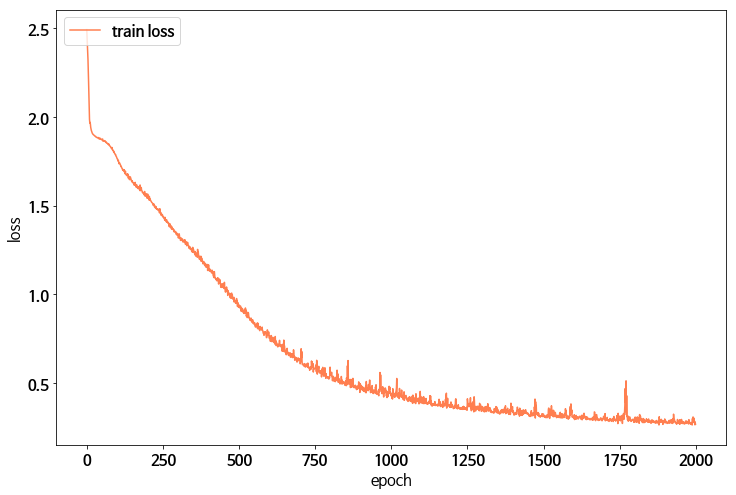

In [9]:
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 15
plt.figure(figsize=(12,8))
plt.plot(history.losses, color='coral')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss'], loc='upper left')
plt.show()

In [10]:
# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

50/50 [==============================] - 0s 2ms/step
acc: 86.00%
one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'g4', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'f4', 'f4', 'f4', 'e8', 'e8', 'e8', 'e8', 'g4', 'g4', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'f4', 'e8', 'd8', 'g8', 'e8', 'd4', 'e8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'f4', 'e8', 'd8', 'g8', 'e8', 'd4', 'e8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8']
